# Paris Airbnb Price

How much should I rent my flat per night?

I use linear regression for predicting the night price of an appartment on Airbnb.
The dataset is available at http://insideairbnb.com/get-the-data.html under a Creative Commons CC0 1.0 Universal (CC0 1.0) "Public Domain Dedication" license.

## 1.Data Preprocessing
If the data file is not uncompressed yet, we have to uncompress it.

In [ ]:
#import gzip
#import shutil
#with gzip.open('data/listing.csv.gz', 'rb') as f_in:
#    with open('data/listing.csv', 'wb') as f_out:
#        shutil.copyfileobj(f_in, f_out)

If Keras is not installed, install it (and reset the session if on a Google Cloud Datalab).

In [ ]:
!pip3 install keras
!pip install Tensorboard

First, we import the required libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import PolynomialFeatures
import keras
from keras.models import Sequential
from keras.layers import Dense
from time import time
from keras.callbacks import TensorBoard
from google.datalab.ml import TensorBoard as tb # if running from a Google Cloud Platform Datalab

Then, we import the dataset and have a look at it.

In [2]:
dataset = pd.read_csv('data/listings.csv', low_memory=False)
print(dataset.columns)
print(dataset.shape)

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms',

There are a lot of variable. 96 to be exact.
Let's keep only the relevant ones, as well as the dependent variable: the price per night!

In [3]:
dataset = dataset[['host_is_superhost','neighbourhood','zipcode','latitude','longitude','property_type',
                   'room_type','accommodates','bathrooms','bedrooms','beds','bed_type','amenities','square_feet','price',
                   'weekly_price','monthly_price','cleaning_fee','number_of_reviews','review_scores_rating',
                   'review_scores_accuracy','review_scores_cleanliness','review_scores_checkin',
                   'review_scores_communication','review_scores_location','review_scores_value']]
dataset.iloc[:5,:]

,host_is_superhost,neighbourhood,zipcode,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,...,monthly_price,cleaning_fee,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
0,f,République,75010,48.869933,2.362511,Loft,Entire home/apt,4,2.0,2.0,...,NaN,$40.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,f,Alésia,75014,48.833494,2.318518,Apartment,Entire home/apt,2,1.0,1.0,...,NaN,$50.00,7,100.0,10.0,10.0,10.0,10.0,10.0,10.0
2,f,Saint-Paul - Ile Saint-Louis,75004,48.851001,2.358690,Apartment,Entire home/apt,2,1.0,0.0,...,"$2,000.00",$36.00,148,94.0,9.0,9.0,10.0,10.0,10.0,10.0
3,t,Le Marais,75004,48.857576,2.352751,Apartment,Entire home/apt,4,1.0,2.0,...,"$2,200.00",$50.00,231,94.0,10.0,9.0,10.0,10.0,10.0,9.0
4,f,Gare du Nord - Gare de I'Est,75009,48.874642,2.343411,Apartment,Entire home/apt,2,1.0,2.0,...,NaN,$60.00,6,96.0,10.0,10.0,10.0,10.0,10.0,10.0


These variables are interesting, but we could do better.
- Some of these are directly related (neighbourhood and zipcode directly depends of latitude and longitude / global review score depends on the other review scores).
- Amenities are a bit difficult to treat for a first version of the algorithm.
- Square feet field is rarely completed
- Prices are treated as strings because they contain the '$' character.
- Weekly and Monthly prices are not always available and we should for now keep these appart.
- We are going to predict the total price which is composed of the price added the cleaning fee.
- When there is no review, the other review variables are considered 'Nan'.
- Sometimes, the other review variables are 'NaN' even though there are reviews.

In [4]:
dataset = dataset.drop(columns=['neighbourhood','zipcode','amenities','square_feet','weekly_price','monthly_price','review_scores_rating'])
dataset['price'] = dataset['price'].replace('[\$,]', '', regex=True).astype(float) + dataset['cleaning_fee'].replace('[\$,]', '', regex=True).astype(float)
dataset = dataset.drop(columns=['cleaning_fee'])
#Reordering the columns
dataset = dataset[['host_is_superhost', 'property_type','room_type','bed_type','latitude','longitude','accommodates','bathrooms','bedrooms','number_of_reviews','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','price']]
dataset = dataset.dropna(subset=['price'])
#Splitting X and y
X = dataset.drop('price',axis='columns')
y = dataset['price']

In [5]:
#Replacing "NaN" values of numerical variables
X_numerical = X.values[:,4:]
imputer = Imputer(missing_values = 'NaN', strategy = 'mean', axis = 0)
imputer = imputer.fit(X_numerical)
X_numerical = imputer.transform(X_numerical)

In [6]:
# Encoding the categorical data
X[['host_is_superhost', 'property_type','room_type','bed_type']] = X[['host_is_superhost', 'property_type','room_type','bed_type']].astype('str').apply(LabelEncoder().fit_transform)

In [7]:
X_categorical = X.values[:,0:3].astype('int64')
onehotencoder = OneHotEncoder()
X_categorical = onehotencoder.fit_transform(X_categorical).toarray()
X = np.append(X_categorical,X_numerical, axis=1)

Looks better! Now let's split the dataset between dependent, independent variables and training and test sets.
We should also encode the categorical data, or, for now, exclude it.

In [9]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
y_train = y_train.values
y_test = y_test.values

Our data has been cleaned. Let's build some machine learning models!
# 2. Models

## 2.1. Linear Regression
Let's build a Linear Regression model!

In [10]:
def linear_regression(X_train, y_train, X_test, y_test):
    # Fitting Simple Linear Regression to the Training set
    regressor = LinearRegression()
    regressor.fit(X_train, y_train)
    train_rmse = sqrt(mean_squared_error(regressor.predict(X_train),y_train))
    test_rmse = sqrt(mean_squared_error(regressor.predict(X_test),y_test))
    return train_rmse, test_rmse

Now that our model is build, we can evaluate it and see the evolution of its training and test losses depending on the dataset size.

In [11]:
lr_eval = pd.DataFrame(0, index=range(100), columns=['train rmse', 'test rmse'])
for i in range(100):
  subset_size = int(round(((i+1)*X_train.shape[0]/100)))
  [lr_eval.values[i,0],lr_eval.values[i,1]] = linear_regression(X_train[:subset_size,:],y_train[:subset_size], X_test, y_test)

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


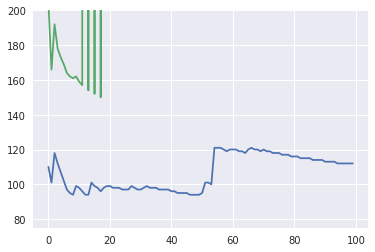

In [12]:
plt.gca().set_ylim([75,200])
plt.plot(lr_eval['train rmse'], label='Training RMSE')
plt.plot(lr_eval['test rmse'], label='Test RMSE')
plt.show()

As we can see, there is a large gap between our training set results and our test set results.
There is a high variance problem, which we might be able to solve by getting more data.

Nevertheless, our training and test set results do not seem to be able to converge more if we keep using this algorithm.
One solution might be to use a smaller set of features, by selecting only the numerical ones.

In [13]:
X_num_train, X_num_test, y_num_train, y_num_test = train_test_split(X_numerical, y, test_size = 0.2)

In [14]:
lr_num_eval = pd.DataFrame(0, index=range(100), columns=['train rmse', 'test rmse'])
for i in range(100):
  subset_size = int(round(((i+1)*X_num_train.shape[0]/100)))
  [lr_num_eval.values[i,0],lr_num_eval.values[i,1]] = linear_regression(X_num_train[:subset_size,:],y_num_train[:subset_size], X_num_test, y_num_test)

Now, let's see the results!

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


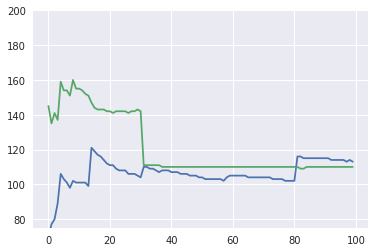

In [15]:
plt.gca().set_ylim([75,200])
plt.plot(lr_num_eval['train rmse'], label='Training RMSE')
plt.plot(lr_num_eval['test rmse'], label='Test RMSE')
plt.show()

## 2.2 Polynomial Regression
Maybe a polynomial model is more adapted to this problem?

In [27]:
def polynomial_regression(X_train,y_train,X_test,y_test, polynomial_degree):
  polynomialFeatures = PolynomialFeatures(degree = polynomial_degree)
  X_train_poly = polynomialFeatures.fit_transform(X_train)
  polynomialFeatures.fit(X_train_poly, y_train)
  polynomial_regressor = LinearRegression()
  polynomial_regressor.fit(X_train_poly, y_train)
  train_rmse = sqrt(mean_squared_error(polynomial_regressor.predict(X_train_poly),y_train))
  test_rmse = sqrt(mean_squared_error(polynomial_regressor.predict(polynomialFeatures.fit_transform(X_test)),y_test))
  return train_rmse,test_rmse

In [17]:
pl_eval = pd.DataFrame(0, index=range(10), columns=['train rmse', 'test rmse'])
for i in range(10):
  print('Polynomial Regression n°{}/10'.format(i+1))
  subset_size = int(round(((i+1)*X_train.shape[0]/10)))
  [pl_eval.values[i,0],pl_eval.values[i,1]] = polynomial_regression(X_train[:subset_size,:],y_train[:subset_size], X_test, y_test, polynomial_degree = 2)

Polynomial Regression n°1/10
Polynomial Regression n°2/10
Polynomial Regression n°3/10
Polynomial Regression n°4/10
Polynomial Regression n°5/10
Polynomial Regression n°6/10
Polynomial Regression n°7/10
Polynomial Regression n°8/10
Polynomial Regression n°9/10
Polynomial Regression n°10/10


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


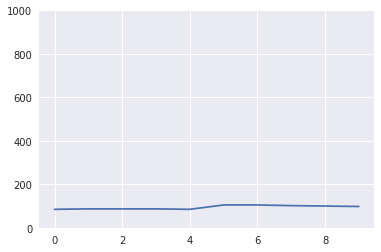

In [28]:
plt.gca().set_ylim([0,1000])
plt.plot(pl_eval['train rmse'], label='Training RMSE')
plt.plot(pl_eval['test rmse'], label='Test RMSE')
plt.show()

This is obviously not right. We should try:
- Reducing the set of features
- Increasing the polynomial degree

In [34]:
pl_num_eval = pd.DataFrame(0, index=range(10), columns=['train rmse', 'test rmse'])
for i in range(10):
  print('Polynomial Regression n°{}/10...'.format(i+1))
  subset_size = int(round(((i+1)*X_num_train.shape[0]/10)))
  [pl_num_eval.values[i,0],pl_num_eval.values[i,1]] = polynomial_regression(X_num_train[:subset_size,:],y_num_train[:subset_size], X_num_test, y_num_test, polynomial_degree = 3)

Polynomial Regression n°1/10...
Polynomial Regression n°2/10...
Polynomial Regression n°3/10...
Polynomial Regression n°4/10...
Polynomial Regression n°5/10...
Polynomial Regression n°6/10...
Polynomial Regression n°7/10...
Polynomial Regression n°8/10...
Polynomial Regression n°9/10...
Polynomial Regression n°10/10...


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


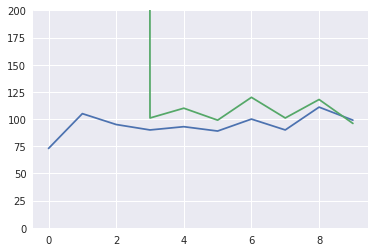

In [37]:
plt.gca().set_ylim([0,200])
plt.plot(pl_num_eval['train rmse'], label='Training RMSE')
plt.plot(pl_num_eval['test rmse'], label='Test RMSE')
plt.show()

This result looks better.
As we can see, the test and train errors are now converging, which suggest a high bias problem for this algorithm.

In order to improve the machine learning predictions, we could try:
- Finding new, relevant, features.
- Increasing further the polynomial degree
- Decreasing lambda, so that the polynomial regression underfits less the training data

## 2.3 Deep Neural Network

Building the Neural Network.

In [38]:
regressor = Sequential()
regressor.add(Dense(kernel_initializer = 'normal', activation = 'relu', input_dim = 46, units = 96))
regressor.add(Dense(kernel_initializer = 'normal', activation = 'relu', input_dim = 96, units = 30))
regressor.add(Dense(kernel_initializer = 'normal', input_dim = 30, units = 1))
# Compiling the ANN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

Training the Neural Network.

In [39]:
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
regressor.fit(X_train, y_train, batch_size = 10, epochs = 50, callbacks=[tensorboard])

Epoch 1/50
34495/34495 [==============================] - 4s 104us/step - loss: 15074.1663
Epoch 2/50
34495/34495 [==============================] - 4s 103us/step - loss: 13008.5314
Epoch 3/50
34495/34495 [==============================] - 4s 120us/step - loss: 12589.5356
Epoch 4/50
34495/34495 [==============================] - 4s 105us/step - loss: 12264.1795
Epoch 5/50
34495/34495 [==============================] - 4s 102us/step - loss: 11914.5273
Epoch 6/50
34495/34495 [==============================] - 3s 100us/step - loss: 11584.4713
Epoch 7/50
34495/34495 [==============================] - 3s 100us/step - loss: 11374.8424
Epoch 8/50
34495/34495 [==============================] - 3s 101us/step - loss: 11269.5788
Epoch 9/50
34495/34495 [==============================] - 3s 100us/step - loss: 11176.6104
Epoch 10/50
34495/34495 [==============================] - 4s 104us/step - loss: 11072.8465
Epoch 11/50
34495/34495 [==============================] - 3s 101us/step - loss: 11111.83

Let's evaluate the model!

In [40]:
y_pred = regressor.predict(X_test)
y_train_pred = regressor.predict(X_train)
dnn_training_rmse = sqrt(mean_squared_error(y_train_pred, y_train))
dnn_test_rmse = sqrt(mean_squared_error(y_pred,y_test))
print(dnn_training_rmse, dnn_test_rmse)

102.39881087433469 103.31999174569644


In [42]:
tb.start('./logs') # Only start it if it is not start yet

TensorBoard was started successfully with pid 9033. Click here to access it.

9033